In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyproj import Transformer
import xskillscore as xskill

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

from stats import clean_xs_ys, get_stats

xr.set_options(keep_attrs = True)

data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/figures/model')

ds = xr.open_dataset(ncs_dir.joinpath('final_50_50.nc'))

insitu = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/all_difference.parq')
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry = gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")
# insitu = insitu.set_index('time1')

interval = pd.read_parquet('/bsuhome/zacharykeskinen/uavsar-validation/data/insitu/storm_boards.parq')
interval = gpd.GeoDataFrame(interval, geometry = gpd.points_from_xy(interval.longitude, interval.latitude), crs="EPSG:4326")

sub = ds[['dem', 'int_phase', 'unw', 'model_d_swe','cum_melt','cor', 'tree_perc','tree_height','model_swe', 'inc', 'delay']]
sub = sub.where((ds['model_swe'].min(dim = 'time') > 0) & (~sub['cor'].mean(dim = 'time1').isnull()))

# get insitu info
densities = np.zeros(len(ds.time1.data))
phases = np.zeros(len(ds.time1.data))
for i, time in enumerate(ds.time1.data):
    insitu_t = insitu[insitu.time1 == time]
    density = np.mean(insitu_t[['t1_density', 't2_density']].mean(axis = 1))
    densities[i] = density
    phases[i] = np.mean(phase_from_depth(insitu_t['dSWE']*997/density, insitu_t['inc'], density = insitu_t[['t1_density', 't2_density']].mean(axis = 1)))
densities = xr.DataArray(densities,
    coords = {'time1':ds.time1.data})
phases = xr.DataArray(phases,
    coords = {'time1':ds.time1.data})

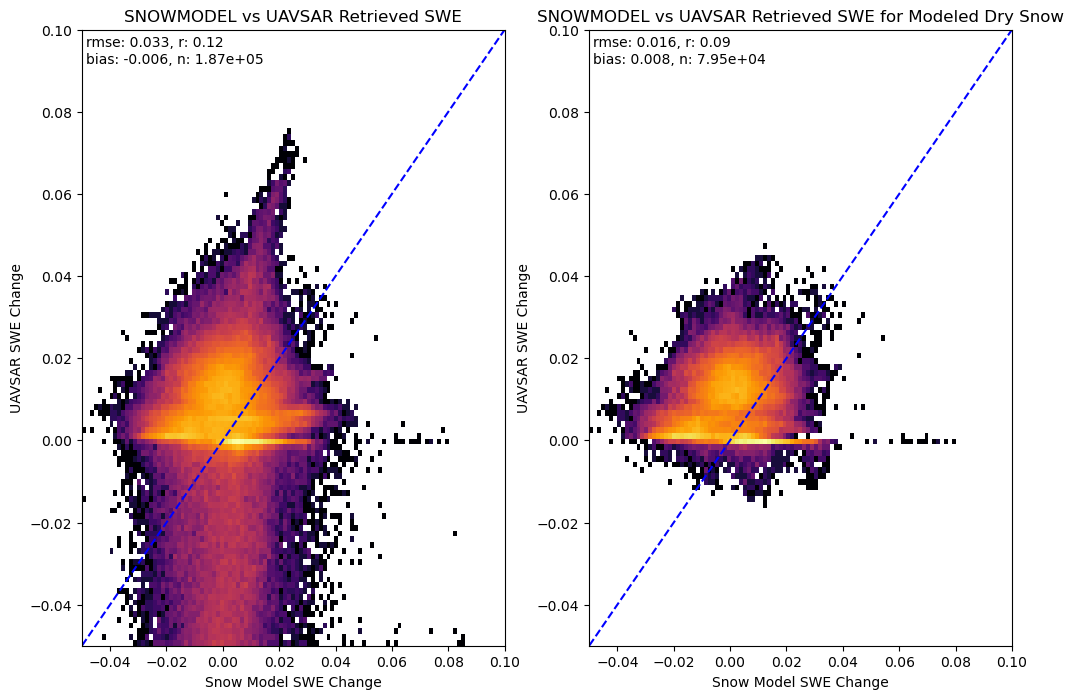

In [8]:
sub['unw_atm'] = sub['unw'] - sub['delay']
# sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - phases)
sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - sub['model_d_swe'].mean(dim = ['x','y']))
unw_d_swe = depth_from_phase(sub['unw_atm'], sub['inc'], density = densities) * densities / 997
unw_d_swe = unw_d_swe.rolling(x = 3, y = 3).mean()
fig, axes = plt.subplots(1,2, figsize = (12, 8))

# sub = sub.drop_sel(time1 = '2021-01-20T21:21:00.000000000')
# unw_d_swe = unw_d_swe.drop_sel(time1 = '2021-01-20T21:21:00.000000000')

xs, ys = clean_xs_ys(unw_d_swe.data.ravel(), sub['model_d_swe'].data.ravel())
xs_best, ys_best = clean_xs_ys(unw_d_swe.data.ravel(), sub['model_d_swe'].where((phases>0)&(sub['cum_melt'] < 0.02)).data.ravel())

for ax, [xs, ys] in zip(axes, [[xs, ys], [xs_best, ys_best]]):
    ax.hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno, range = [[-0.05, 0.09],[-0.05, 0.09]]) # range = [[-0.25, 0.09],[-0.25, 0.09]], # , norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno

    ax.set_xlabel('Snow Model SWE Change')
    ax.set_ylabel('UAVSAR SWE Change')
    ax.set_xlim(-0.05, 0.1)
    ax.set_ylim(-0.05, 0.1)
    ax.plot([-0.1,0.2], [-0.1,0.2], color = 'blue', linestyle = 'dashed')
    rmse, r, n, bias = get_stats(xs, ys, bias = True)
    ax.text(s = f'rmse: {rmse:.3f}, r: {r:.2f}\nbias: {bias:.3f}, n: {n:.2e}', x = 0.01,y= 0.99 , ha = 'left', va = 'top', transform = ax.transAxes)

# axes[0].text(s = 'A', x = 0.99,y= 0.94 , ha = 'right', va = 'top', weight = 'bold', transform = axes[0].transAxes)
# axes[1].text(s = 'B', x = 0.99,y= 0.94 , ha = 'right', va = 'top',weight = 'bold',transform = axes[1].transAxes)


axes[0].set_title('SNOWMODEL vs UAVSAR Retrieved SWE')
axes[1].set_title('SNOWMODEL vs UAVSAR Retrieved SWE for Modeled Dry Snow')
plt.savefig(fig_dir.joinpath('uavsar_snowmodel_scatter_unw.png'))

In [95]:
sub['unw_atm'] = sub['int_phase'] - sub['delay']
sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - phases)
unw_d_swe = depth_from_phase(sub['unw_atm'], sub['inc'], density = densities) * densities / 997

fig, axes = plt.subplots(4, 1, figsize = (12, 8))
rs = np.zeros(ds.time1.size)
melt = np.zeros(ds.time1.size)
coh = np.zeros(ds.time1.size)
acc = np.zeros(ds.time1.size)
delay = np.zeros(ds.time1.size)

i = 0
for t in ds.time1.data:
    sub_t = sub.sel(time1= t)
    xs, ys = clean_xs_ys(unw_d_swe.sel(time1 = t).data.ravel(), sub_t['model_d_swe'].data.ravel())
        
    rmse, r, n = get_stats(xs, ys)
    rs[i] = rmse
    melt[i] = sub_t['cum_melt'].mean()
    coh[i] = sub_t['cor'].mean()
    acc[i]= sub_t['model_d_swe'].mean()
    delay[i] = sub_t['delay'].mean()
    i += 1

axes[0].scatter(x = melt, y = rs)
axes[1].scatter(x = coh, y = rs)
axes[2].scatter(x = acc, y = rs)
axes[3].scatter(x = delay, y = rs)

KeyError: 'int_phse'

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


/bsuhome/zacharykeskinen/miniconda3/envs/validation/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


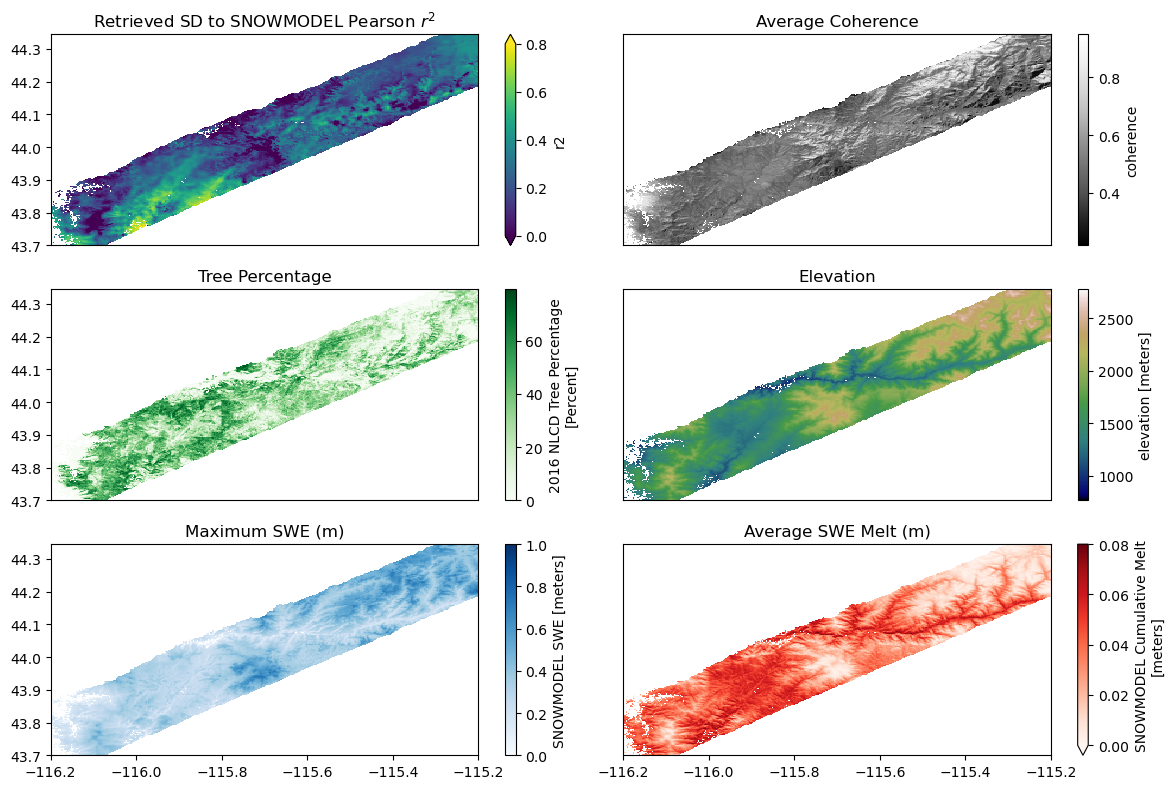

In [74]:
# model_phase = phase_from_depth(sub['model_d_swe']*997/250, sub['inc'], density = 250)
sub['unw_atm'] = sub['int_phase'] - sub['delay']

sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - phases)
unw_d_swe = depth_from_phase(sub['unw_atm'], sub['inc'], density = densities) * densities / 997
unw_d_swe = unw_d_swe.rolling(x = 4, y = 4, min_periods=3).mean()

fig, axes = plt.subplots(3, 2, figsize = (12, 8))
sub['r2'] = xskill.pearson_r(unw_d_swe, sub['model_d_swe'], dim = 'time1', skipna = True)

sub['r2'].plot(vmax = 0.8, vmin = 0, ax= axes[0,0])
axes[0,0].set_title('Retrieved SD to SNOWMODEL Pearson $r^{2}$')

sub['cor'].mean(dim = 'time1').plot(ax = axes[0,1], cmap = 'Greys_r')
axes[0,1].set_title('Average Coherence')

sub['tree_perc'].plot(ax = axes[1, 0], cmap = 'Greens')
axes[1, 0].set_title('Tree Percentage')

sub['dem'].plot(ax = axes[1,1], cmap = 'gist_earth')
axes[1,1].set_title('Elevation')

sub['cum_melt'].mean(dim = 'time1').plot(ax = axes[2, 1], vmin = 0, vmax = 0.08, cmap = 'Reds')
axes[2, 1].set_title('Average SWE Melt (m)')

# xr.apply_ufunc(np.rad2deg, sub['inc']).plot(ax = axes[2, 0], cmap = 'Greys')
# axes[2, 0].set_title('Incidence Angle')

sub['model_swe'].max(dim = 'time').plot(ax = axes[2, 0], vmin = 0, vmax = 1, cmap = 'Blues')
axes[2, 0].set_title('Maximum SWE (m)')

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(43.7, 44.345)
    ax.set_xlim(-116.2,-115.2)

for ax in axes[:, 1]:
    ax.set_yticks([])

for ax in axes[:2, :].ravel():
    ax.set_xticks([])


plt.tight_layout()
plt.savefig(fig_dir.joinpath('r2_maps.png'))

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


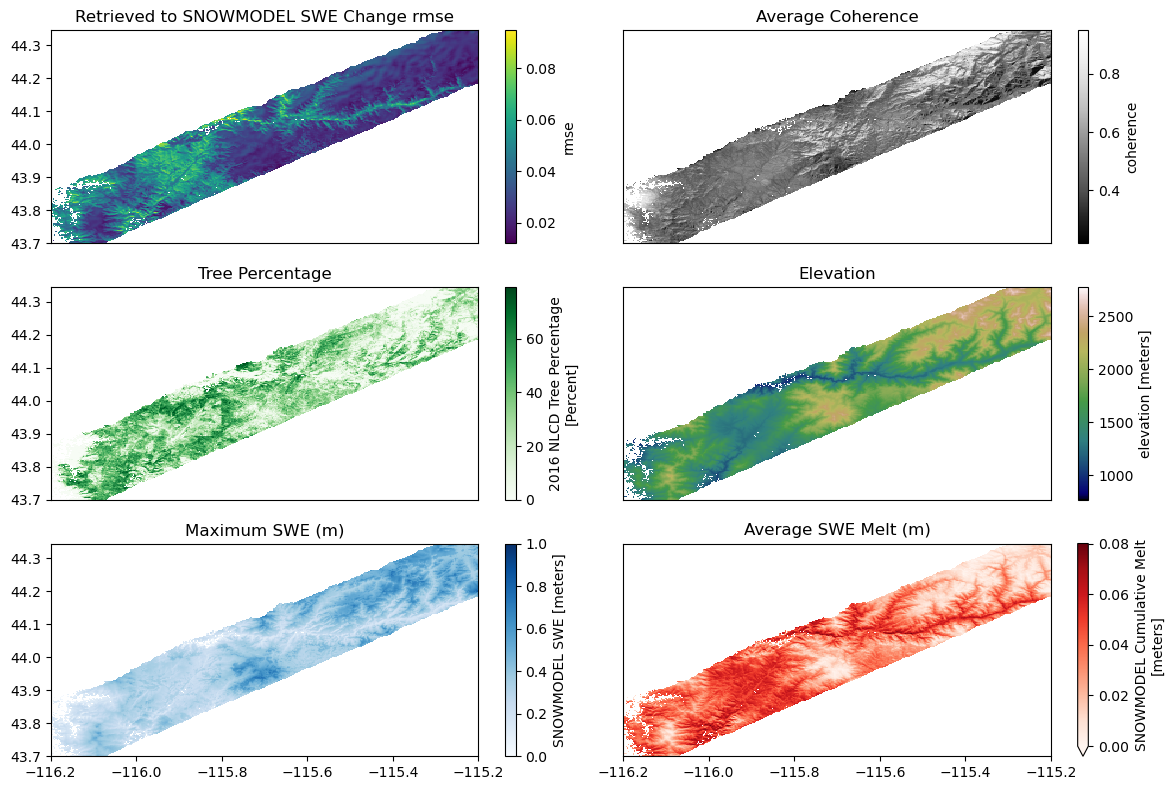

In [90]:
# model_phase = phase_from_depth(sub['model_d_swe']*997/250, sub['inc'], density = 250)
sub['unw_atm'] = sub['int_phase'] - sub['delay']

sub['unw_atm'] = sub['unw_atm'] - (sub['unw_atm'].mean(dim = ['x','y']) - phases)
unw_d_swe = depth_from_phase(sub['unw_atm'], sub['inc'], density = densities) * densities / 997
unw_d_swe = unw_d_swe.rolling(x = 4, y = 4, min_periods=3).mean()

fig, axes = plt.subplots(3, 2, figsize = (12, 8))
sub['rmse'] = xskill.rmse(unw_d_swe, sub['model_d_swe'], dim = 'time1', skipna = True)

sub['rmse'].plot(ax= axes[0,0])
axes[0,0].set_title('Retrieved to SNOWMODEL SWE Change rmse')

sub['cor'].mean(dim = 'time1').plot(ax = axes[0,1], cmap = 'Greys_r')
axes[0,1].set_title('Average Coherence')

sub['tree_perc'].plot(ax = axes[1, 0], cmap = 'Greens')
axes[1, 0].set_title('Tree Percentage')

sub['dem'].plot(ax = axes[1,1], cmap = 'gist_earth')
axes[1,1].set_title('Elevation')

sub['cum_melt'].mean(dim = 'time1').plot(ax = axes[2, 1], vmin = 0, vmax = 0.08, cmap = 'Reds')
axes[2, 1].set_title('Average SWE Melt (m)')

# xr.apply_ufunc(np.rad2deg, sub['inc']).plot(ax = axes[2, 0], cmap = 'Greys')
# axes[2, 0].set_title('Incidence Angle')

sub['model_swe'].max(dim = 'time').plot(ax = axes[2, 0], vmin = 0, vmax = 1, cmap = 'Blues')
axes[2, 0].set_title('Maximum SWE (m)')

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(43.7, 44.345)
    ax.set_xlim(-116.2,-115.2)

for ax in axes[:, 1]:
    ax.set_yticks([])

for ax in axes[:2, :].ravel():
    ax.set_xticks([])


plt.tight_layout()
plt.savefig(fig_dir.joinpath('rmse_maps.png'))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


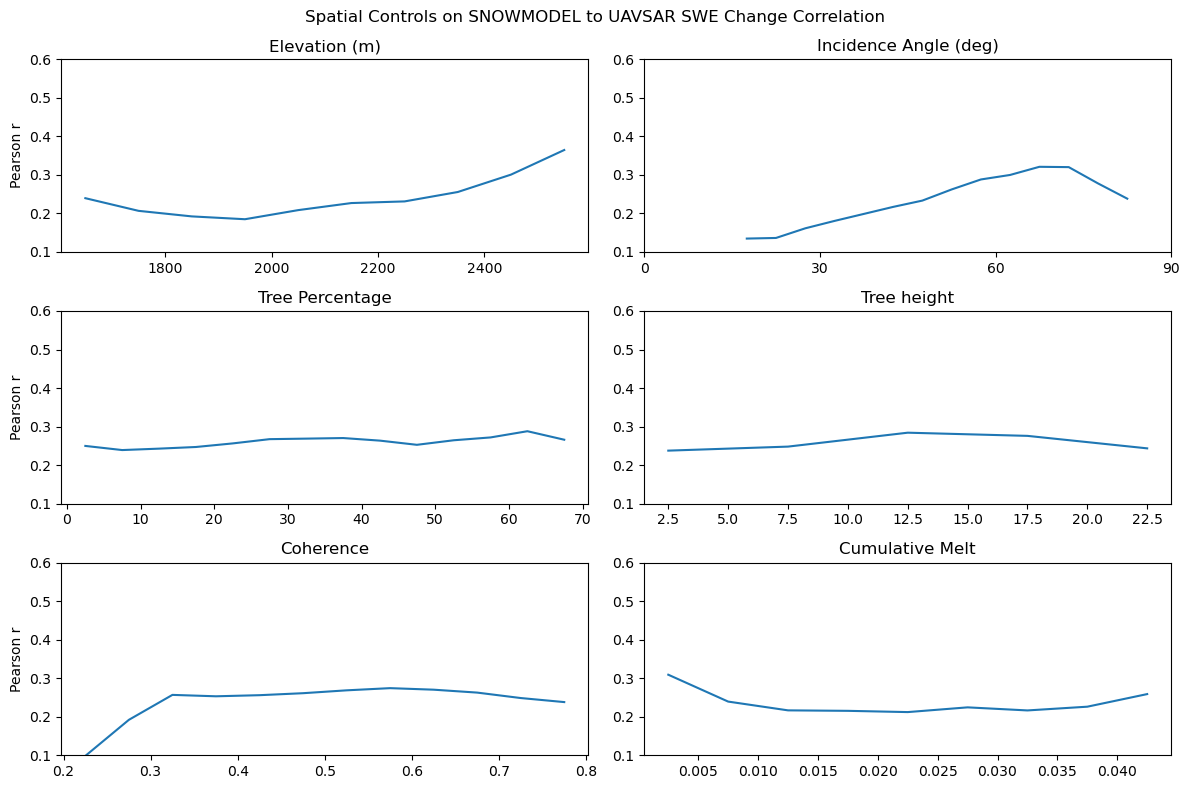

In [75]:
fig, axes = plt.subplots(3,2, figsize = (12, 8))

## elevation
ax = axes[0,0]
dem_group = sub.groupby_bins('dem', np.arange(1600, 2700, 100))
dem_group = dem_group.mean()['r2'].where(dem_group.count()['r2'] > 100)
dem_group.plot(ax = ax)
ax.set_title('Elevation (m)')

## Incidence Angle
ax = axes[0, 1]
inc_group = sub.groupby_bins('inc', np.arange(0, np.deg2rad(90), np.deg2rad(5)))
inc_group = inc_group.mean()['r2'].where(inc_group.count()['r2'] > 100)
inc_group.plot(ax = ax)
ax.set_title('Incidence Angle (deg)')

# convert to degrees
tick_locs = np.deg2rad([0, 30, 60, 90])
tick_lbls = [0, 30, 60, 90]
ax.set_xticks(tick_locs, tick_lbls)

## tree height
ax = axes[1,1]
tree_group = sub.groupby_bins('tree_height', np.arange(0, 100, 5))
tree_group = tree_group.mean()['r2'].where(tree_group.count()['r2'] > 100)
tree_group.plot(ax = ax)
ax.set_title('Tree height')

## tree percentage

ax = axes[1,0]
tree_group= sub.groupby_bins('tree_perc', np.arange(0, 100, 5))
tree_group = tree_group.mean()['r2'].where(tree_group.count()['r2'] > 100)
tree_group.plot(ax = ax)
ax.set_title('Tree Percentage')

## Coherence

ax = axes[2, 0]
cor_group = sub.groupby_bins('cor', np.arange(0, 0.85, 0.05))
cor_group = cor_group.mean()['r2'].where(cor_group.count()['r2'] > 100)
cor_group.plot(ax = ax)
ax.set_title('Coherence')

## Cumulative Melt

ax = axes[2,1]
sub['ave_cum_melt'] = sub['cum_melt'].mean(dim = 'time1')
melt_group = sub.groupby_bins('ave_cum_melt', np.arange(0, 0.05, 0.005))
melt_group = melt_group.mean()['r2'].where(melt_group.count()['r2'] > 100)
melt_group.plot(ax = ax)
ax.set_title('Cumulative Melt')

for ax in axes[:,0]:
    ax.set_ylabel('Pearson r')

for ax in axes[:,1]:
    ax.set_ylabel('')

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylim(0.1, 0.6)

plt.suptitle('Spatial Controls on SNOWMODEL to UAVSAR SWE Change Correlation')

plt.tight_layout()

plt.savefig(fig_dir.joinpath('r2_binned.png'))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


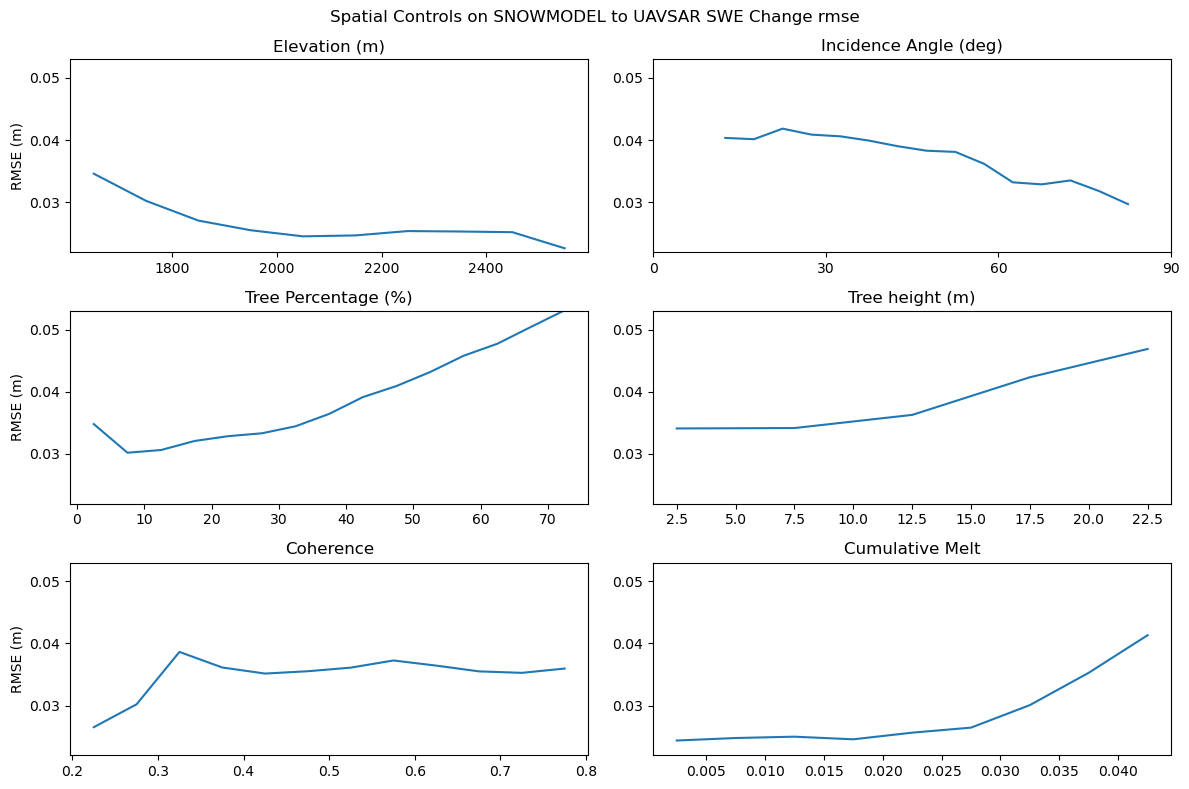

In [89]:
fig, axes = plt.subplots(3,2, figsize = (12, 8))

## elevation
ax = axes[0,0]
dem_group = sub.groupby_bins('dem', np.arange(1600, 2700, 100))
dem_group = dem_group.mean()['rmse'].where(dem_group.count()['rmse'] > 10)
dem_group.plot(ax = ax)
ax.set_title('Elevation (m)')

## Incidence Angle
ax = axes[0, 1]
inc_group = sub.groupby_bins('inc', np.arange(0, np.deg2rad(90), np.deg2rad(5)))
inc_group = inc_group.mean()['rmse'].where(inc_group.count()['rmse'] > 10)
inc_group.plot(ax = ax)
ax.set_title('Incidence Angle (deg)')

# convert to degrees
tick_locs = np.deg2rad([0, 30, 60, 90])
tick_lbls = [0, 30, 60, 90]
ax.set_xticks(tick_locs, tick_lbls)

## tree height
ax = axes[1,1]
tree_group = sub.groupby_bins('tree_height', np.arange(0, 100, 5))
tree_group = tree_group.mean()['rmse'].where(tree_group.count()['rmse'] > 10)
tree_group.plot(ax = ax)
ax.set_title('Tree height (m)')

## tree percentage

ax = axes[1,0]
tree_group= sub.groupby_bins('tree_perc', np.arange(0, 100, 5))
tree_group = tree_group.mean()['rmse'].where(tree_group.count()['rmse'] > 10)
tree_group.plot(ax = ax)
ax.set_title('Tree Percentage (%)')

## Coherence

ax = axes[2, 0]
cor_group = sub.groupby_bins('cor', np.arange(0, 0.85, 0.05))
cor_group = cor_group.mean()['rmse'].where(cor_group.count()['rmse'] > 10)
cor_group.plot(ax = ax)
ax.set_title('Coherence')

## Cumulative Melt

ax = axes[2,1]
sub['ave_cum_melt'] = sub['cum_melt'].mean(dim = 'time1')
melt_group = sub.groupby_bins('ave_cum_melt', np.arange(0, 0.05, 0.005))
melt_group = melt_group.mean()['rmse'].where(melt_group.count()['rmse'] > 10)
melt_group.plot(ax = ax)
ax.set_title('Cumulative Melt')

for ax in axes[:,0]:
    ax.set_ylabel('RMSE (m)')

for ax in axes[:,1]:
    ax.set_ylabel('')

for ax in axes.ravel():
    ax.set_xlabel('')
    ax.set_ylim(0.022, 0.053)

plt.suptitle('Spatial Controls on SNOWMODEL to UAVSAR SWE Change rmse')

plt.tight_layout()

plt.savefig(fig_dir.joinpath('rmse_binned.png'))